In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import random
import train
from model import NNModel, NNModelEx, CNNModel

pd.set_option('display.max_columns', 999)

In [2]:
# For this model, the data preprocessing part is already completed with the exception of scaling.
# so we just need to scale here.

In [3]:
def get_ref_X_y(df):
    X_cols = [c for c in df.columns if not c.startswith('close__')]
    y_cols = [c for c in df.columns if c.startswith('close__')]
    return (df[X_cols], df[y_cols])

In [4]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'./data/{key}.pkl')
    return raw[key]

In [5]:
configurations = {
    'dataset' : 'tc0_', # '', 'sample_', 'secret_'
    'model_identifier' : "tc0_2",
    'model_path' : f"./models",
    'model': NNModelEx,
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 3e-3,
    'momentum' : 0.99, #SGD
    'weight_decay' : 0.3, #Adam
    'max_epochs' : 50000,
    'do_validate' : True,
    'model_definition' : [
        ('l', (500,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
    ],
    'train_params' : {
        'batch_size': 10000,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 1,
        'pin_memory': True,
    },
}

configurations = {
    'dataset' : 'tc0_', # '', 'sample_', 'secret_'
    'model_identifier' : "tc0_3",
    'model_path' : f"./models",
    'model': NNModelEx,
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 5e-3,
    'momentum' : 0.99, #SGD
    'weight_decay' : 0.3, #Adam
    'max_epochs' : 50000,
    'do_validate' : True,
    'model_definition' : [
        ('l', (600,)), ('r', (True,)),
        ('l', (600,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
        ('l', (500,)), ('r', (True,)),
        ('l', (400,)), ('r', (True,)),
        ('l', (400,)), ('r', (True,)),
        ('l', (300,)), ('r', (True,)),
        ('l', (300,)), ('r', (True,)),
        ('l', (200,)), ('r', (True,)),
        ('l', (200,)), ('r', (True,)),
        ('l', (100,)), ('r', (True,)),
        ('l', (100,)), ('r', (True,)),
        ('l', (50,)), ('r', (True,)),
        ('l', (50,)), ('r', (True,)),
    ],
    'train_params' : {
        'batch_size': 20000,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 1,
        'pin_memory': True,
    },
}

In [6]:
%%time

train_df = load_data(raw_data,dataset=configurations['dataset'],validation=False)
test_df = load_data(raw_data,dataset=configurations['dataset'],validation=True)

X_train, y_train = get_ref_X_y(train_df)
X_test, y_test = get_ref_X_y(test_df)

X_train = X_train.copy()
X_test = X_test.copy()

for c in X_train.columns:
    if c.startswith('high_') or c.startswith('low_') or c.startswith('close_'):
        X_train.loc[:,c] = ((X_train[c] / X_train['open']) - 1) * 50
        X_test.loc[:,c] = ((X_test[c] / X_test['open']) - 1) * 50

X_train.drop(columns=['open'], inplace=True)
X_test.drop(columns=['open'], inplace=True)

Loading data to cache for: tc0_train
Loading data to cache for: tc0_test
CPU times: user 3.48 s, sys: 6.45 s, total: 9.93 s
Wall time: 12.2 s


In [10]:
import torch

net, loss_func, optimizer, mean_losses, next_epoch, = train.load_model_with_config(configurations, X_train, False)

optimizer = torch.optim.AdamW(net.parameters(), lr=5e-5, weight_decay=5e-3, eps=1e-7, amsgrad=False)


train.save_model_with_config(configurations, net=net, loss_func=loss_func, optimizer=optimizer,
                   mean_losses=mean_losses, next_epoch=next_epoch+1,
                  )


Loading existing model


In [11]:
model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model
NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=408, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=400, bias=True)
    (9): ReLU()
    (10): Linear(in_features=400, out_features=400, bias=True)
    (11): ReLU()
    (12): Linear(in_features=400, out_features=300, bias=True)
    (13): ReLU()
    (14): Linear(in_features=300, out_features=300, bias=True)
    (15): ReLU()
    (16): Linear(in_features=300, out_features=200, bias=True)
    (17): ReLU()
    (18): Linear(in_features=200, out_features=200, bias=True)
    (19): ReLU()
    (20): Linear(in_features=200, out_features=100, bias=True)
    (21): ReLU()
    (22): Linear(in_features=100, out_features=100, bias=True)
    (23): Re

  0%|          | 0/49999 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

Loading existing model


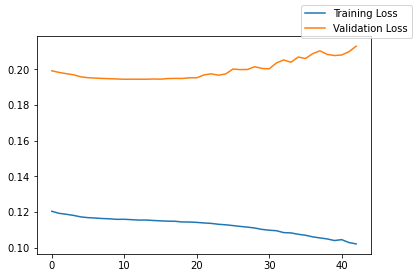

In [12]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [ ]:
trained_model = model

In [ ]:
y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_test_pred = train.predict(trained_model, X_test, y_test, device="cpu") # get predictions for each train
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)  # put results into a dataframe

In [ ]:
print(f'    Train set MAE (L1) loss: {mean_absolute_error(y_train, y_train_pred_df)}')
print(f'    Train set MSE (L2) loss: {mean_squared_error(y_train, y_train_pred_df)}')

# random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)

print("Train - Ground Truth (normalized):")
display(y_train)
# print("Train - Ground Truth (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df)
# print("Train - Prediction (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

In [ ]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_test_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_test_pred_df)}')

random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)
# sample = [0,1]

print("Train - Ground Truth (normalized):")
display(y_train.loc)
# print("Train - Ground Truth (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df.loc)
# print("Train - Prediction (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

In [ ]:
# errors = y_train.loc[sample].iloc[:,3:] - y_train_pred_df.loc[sample]

# display(errors)

# display(errors.std())

# display(y_train.loc[sample].iloc[:,3:])
# display(y_train_pred_df.loc[sample])

In [ ]:
# def row_to_compare(X, y, y_pred, row):
#     epoch = X.iloc[row].EPOCH_y
#     X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
#     y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
#     y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

#     # Ground truth
#     y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y0.ECCENTRICITY,
#                                           aop=y0.ARG_OF_PERICENTER,
#                                           inc=y0.INCLINATION,
#                                           mea=y0.MEAN_ANOMALY,
#                                           mem=y0.MEAN_MOTION,
#                                           raa=y0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Prediction
#     y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y1.ECCENTRICITY,
#                                           aop=y1.ARG_OF_PERICENTER,
#                                           inc=y1.INCLINATION,
#                                           mea=y1.MEAN_ANOMALY,
#                                           mem=y1.MEAN_MOTION,
#                                           raa=y1.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Propigation
#     y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
#                                           ecc=X0.ECCENTRICITY,
#                                           aop=X0.ARG_OF_PERICENTER,
#                                           inc=X0.INCLINATION,
#                                           mea=X0.MEAN_ANOMALY,
#                                           mem=X0.MEAN_MOTION,
#                                           raa=X0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     print(f'Ground Truth: {y0_xyz}')
#     print(f'Predicted: {y1_xyz}')
#     print(f'Propigation: {y2_xyz}')
    
#     print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
#     print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

# for row in range(2):
#     print (f'Row {row}:')
#     row_to_compare(X_train, y_train, y_train_pred_df, row)
#     print('')